https://github.com/hummat/saliency/blob/master/tutorial.ipynb


others

https://github.com/PAIR-code/saliency


and

https://github.com/experiencor/deep-viz-keras

# Computing saliency masks in PyTorch
This notebook demonstrates how to compute saliency masks in PyTorch using various methods and neural network models. The following techniques are demonstrated:
* Vanilla Gradient
* Guided Backpropagation (and its SmoothGrad variant)
* Integrated Gradients
* Grad-CAM
* XRAI

In [ ]:
!git clone https://github.com/hummat/saliency.git

Cloning into 'saliency'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 122 (delta 46), reused 72 (delta 11), pack-reused 0
Receiving objects: 100% (122/122), 3.42 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [ ]:
!pip install colorcet

In [ ]:
%cd /content/saliency

# Standard imports 
import numpy as np
from matplotlib import pyplot as plt
import colorcet as cc
import torchvision

# From the repository
from utils import load_image, make_grayscale, make_black_white, show_mask, show_mask_on_image, cut_image_with_mask
from vanilla_gradient import VanillaGradient
from guided_backprop import GuidedBackprop
from integrated_gradients import IntegratedGradients
from grad_cam import GradCam
from xrai import XRAI

/content/saliency


In [ ]:
# Load a model. Make sure to have modified the model as described in the remarks section
# of the repository readme file when using GoogLeNet and Inception models
# with Guided Backpropagation or Grad-CAM techniques.
model = torchvision.models.googlenet(pretrained=True)

# Load an image. Standard input size for GoogLeNet/Inception is 299px.
doberman = load_image('/content/dogs.jpg', size=299)

## Vanilla Gradient
The simplest approach to solve the attribution problem (which pixels in the input image are most responsible for the class prediction?). As you can see, the result gives a general impression about the location of the object, but is otherwise quite noisy.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


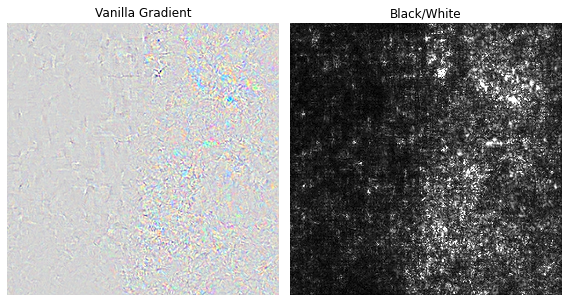

In [ ]:
# Construct a saliency object and compute the saliency mask.
vanilla_gradient = VanillaGradient(model)
rgb_mask = vanilla_gradient.get_mask(image_tensor=doberman)

# Make a black and white variant of the computed saliency mask.
bw_mask = make_black_white(rgb_mask)

# Plot the RGB and black/white version alongside each other.
figure, axes = plt.subplots(1, 2, figsize=(8, 8), tight_layout=True)
show_mask(rgb_mask, title='Vanilla Gradient', axis=axes[0])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[1])

## Guided Backpropagation and SmoothGrad
By modifying how the gradient flows through the ReLU non-linearities, the noise can be reduced substantially. This was already done in the Deconvolution approach of which Guided Backpropagation is a generalization. By adding Gaussian noise to the input image and averaging multiple output masks, the noise can be further reduced, which is the idea behind the SmoothGrad method.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


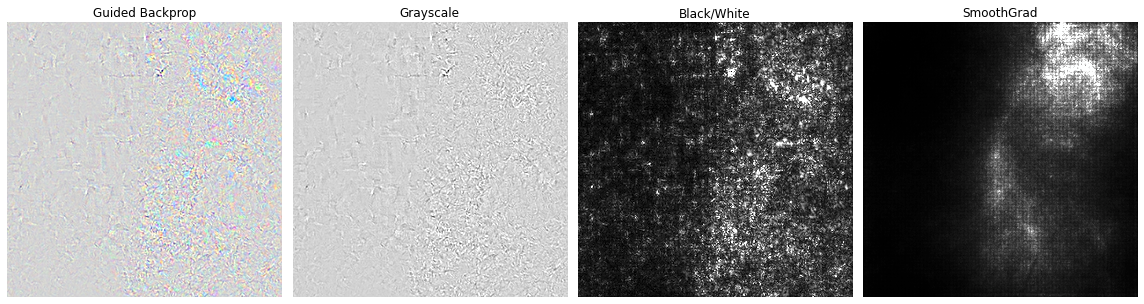

In [ ]:
guided_backprop = GuidedBackprop(model)
rgb_mask = guided_backprop.get_mask(image_tensor=doberman)

# Vanilla Gradient, Guided Backpropagation and Integrated Gradients
# also implement a SmmothGrad variant of their saliency mask.
smooth_rgb_mask = guided_backprop.get_smoothed_mask(image_tensor=doberman, samples=50)

# ReLUs are modified in PyTorch using hooks
# which we need to remove after we are done.
guided_backprop.remove_hooks()

gray_mask = make_grayscale(rgb_mask)
bw_mask = make_black_white(rgb_mask)
smooth_bw_mask = make_black_white(smooth_rgb_mask)

figure, axes = plt.subplots(1, 4, figsize=(16, 16), tight_layout=True)
show_mask(rgb_mask, title='Guided Backprop', axis=axes[0])
show_mask(gray_mask, title='Grayscale', cmap=cc.cm.gray, axis=axes[1])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[2])
show_mask(smooth_bw_mask, title='SmoothGrad', cmap=cc.cm.gray, axis=axes[3])

In [ ]:
# Let's try another model
model = torchvision.models.resnet50(pretrained=True)
# Reload the image as the standard input size for ResNets is 224px.
doberman = load_image('/content/dogs.jpg', size=224)

## Integrated Gradients
Starting from a baseline image (often a completely black image), we obtain the Integrated Gradients result by adding a fraction of the difference between this baseline and the input image to the baseline and computing its gradient for multiple fractions (steps), finally averaging the results. This method features some appealing theoretical properties, outlined in the corresponding paper, which other methods lack.

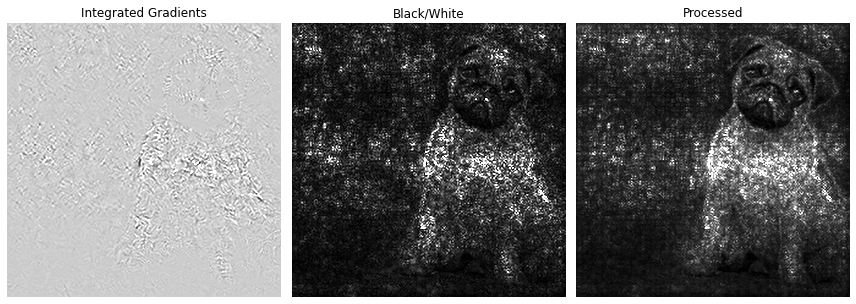

In [ ]:
integrated_gradients = IntegratedGradients(model)
rgb_mask = integrated_gradients.get_mask(image_tensor=doberman)

# Individual gradients can be processed before being integrated
# by passing a function to the 'process' parameter of the
# 'get_mask' method. By passing e.g. 'np.abs' the visual result
# can be improved.
abs_rgb_mask = integrated_gradients.get_mask(image_tensor=doberman, process=np.abs)

gray_mask = make_grayscale(rgb_mask)
bw_mask = make_black_white(rgb_mask)
bw_mask_alt = make_black_white(abs_rgb_mask)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(gray_mask, title='Integrated Gradients', cmap=cc.cm.gray, axis=axes[0])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[1])
show_mask(bw_mask_alt, title='Processed', cmap=cc.cm.gray, axis=axes[2])

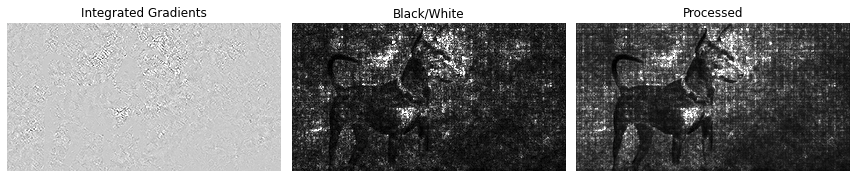

In [ ]:
integrated_gradients = IntegratedGradients(model)
rgb_mask = integrated_gradients.get_mask(image_tensor=doberman)

# Individual gradients can be processed before being integrated
# by passing a function to the 'process' parameter of the
# 'get_mask' method. By passing e.g. 'np.abs' the visual result
# can be improved.
abs_rgb_mask = integrated_gradients.get_mask(image_tensor=doberman, process=np.abs)

gray_mask = make_grayscale(rgb_mask)
bw_mask = make_black_white(rgb_mask)
bw_mask_alt = make_black_white(abs_rgb_mask)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(gray_mask, title='Integrated Gradients', cmap=cc.cm.gray, axis=axes[0])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[1])
show_mask(bw_mask_alt, title='Processed', cmap=cc.cm.gray, axis=axes[2])

In [ ]:
# Load another image and define a target class.
cat_dog = load_image('/content/index.jpeg', size=224)
class_boxer = 243  # Class 'bull mastiff
class_cat = 282  # Class 'tiger cat'

## Grad-CAM and Guided Grad-CAM
Instead of focusing on the influence of individual pixels, a region based method is often visually easier to interpret. In the Grad-CAM approach, one computes the gradient of the output of the neural network w.r.t. the weights of its (last) convolutional layer, and weighs the output of this layer by the magnitued of the gradient summed over the channels.

Guided Grad-CAM combines the Grad-CAM region with the result from the pixel-based, class agnostic, Guided Backpropagation to obtain a detailed, yet class discriminative saliency mask.

In [ ]:
guided_backprop = GuidedBackprop(model)

# So far, the target class was set to the networks' prediction implicitly.
# Now, we define a desired target class explicitly.
boxer_mask = guided_backprop.get_mask(image_tensor=cat_dog, target_class=class_boxer)
cat_mask = guided_backprop.get_mask(image_tensor=cat_dog, target_class=class_cat)
guided_backprop.remove_hooks()

grad_cam = GradCam(model)
boxer_region = grad_cam.get_mask(image_tensor=cat_dog, target_class=class_boxer)
cat_region = grad_cam.get_mask(image_tensor=cat_dog, target_class=class_cat)
grad_cam.remove_hooks()

# 'Guided Grad-CAM' is a combination of the 'Guided Backprop' and 'Grad-CAM' method.
guided_grad_cam_boxer = guided_backprop.apply_region(boxer_mask, boxer_region)
guided_grad_cam_cat = guided_backprop.apply_region(cat_mask, cat_region)

figure, axes = plt.subplots(1, 4, figsize=(16, 16), tight_layout=True)
show_mask_on_image(image_path='/content/cat_dog.jpeg', mask=boxer_region, title='Grad-CAM on image: Boxer', axis=axes[0])
show_mask_on_image(image_path='/content/cat_dog.jpeg', mask=cat_region, title='Grad-CAM on image: Cat', axis=axes[1])
show_mask(guided_grad_cam_boxer, title='Guided Grad-CAM: Boxer', axis=axes[2])
show_mask(guided_grad_cam_cat, title='Guided Grad-CAM: Cat', axis=axes[3])

## XRAI
The final and most recent method computes multiple regions of interest which are importance-weighted using the result of two Integrated Gradients masks, one from a black and one from a white baseline.

In [ ]:
# Yet another model.
model = torchvision.models.inception_v3(pretrained=True)
doberman = load_image('/content/index.jpeg', size=299)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


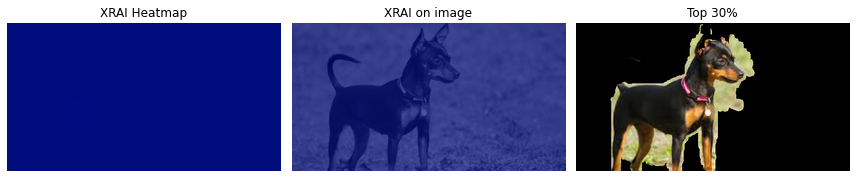

In [ ]:
xrai = XRAI(model)
segments = xrai.get_mask(image_tensor=doberman)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(segments, title='XRAI Heatmap', cmap=cc.cm.bmy, norm=False, axis=axes[0])
show_mask_on_image(image_path='/content/index.jpeg', mask=segments, title='XRAI on image', axis=axes[1])
cut_image_with_mask(image_path='/content/index.jpeg', mask=segments, title='Top 30%', percentile=70, axis=axes[2])

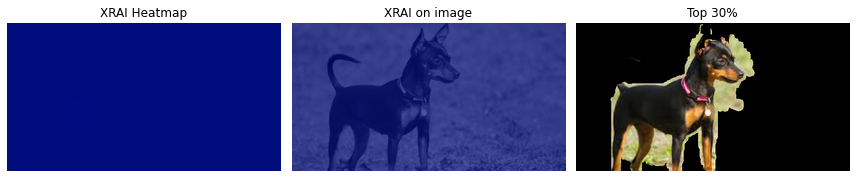

In [ ]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(segments, title='XRAI Heatmap', cmap=cc.cm.bmy, norm=False, axis=axes[0])
show_mask_on_image(image_path='/content/index.jpeg', mask=segments, title='XRAI on image', axis=axes[1])
cut_image_with_mask(image_path='/content/index.jpeg', mask=segments, title='Top 30%', percentile=70, axis=axes[2])

In [ ]:
# Yet another model.
model = torchvision.models.inception_v3(pretrained=True)
doberman = load_image('/content/dogs.jpg', size=299)

In [ ]:
doberman.shape

torch.Size([1, 3, 299, 299])

In [ ]:
from PIL import Image

In [ ]:
im = Image.open('/content/index.jpeg').resize((299,299))
#im.save('/content/index.jpeg')

In [ ]:
'''im = np.asarray(im)
im.shape'''

(299, 299, 3)

In [ ]:
xrai = XRAI(model)
segments = xrai.get_mask(image_tensor=doberman)

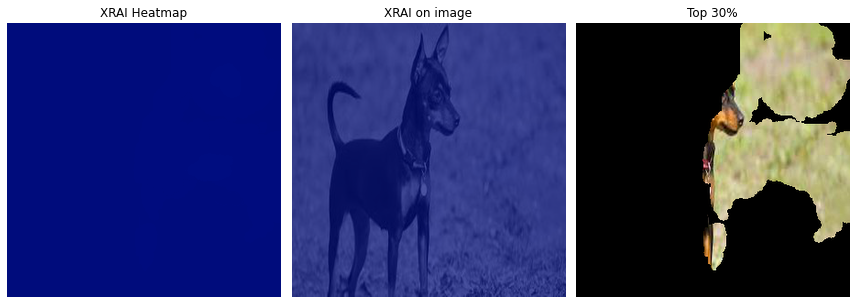

In [ ]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(segments, title='XRAI Heatmap', cmap=cc.cm.bmy, norm=False, axis=axes[0])
show_mask_on_image(image_path='/content/index.jpeg', mask=segments, title='XRAI on image', axis=axes[1])
cut_image_with_mask(image_path='/content/index.jpeg', mask=segments, title='Top 30%', percentile=70, axis=axes[2])

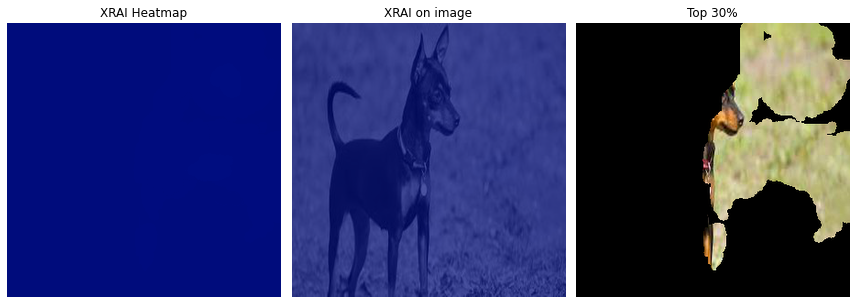

In [ ]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(segments, title='XRAI Heatmap', cmap=cc.cm.bmy, norm=False, axis=axes[0])
show_mask_on_image(image_path='/content/index.jpeg', mask=segments, title='XRAI on image', axis=axes[1])
cut_image_with_mask(image_path='/content/index.jpeg', mask=segments, title='Top 30%', percentile=70, axis=axes[2])